<a href="https://colab.research.google.com/github/Apoorvmittal11/23-CS-072-ML-LAB-EXPERIMENT/blob/main/23-CS-072%20EXPERIMENT5/23_CS_072_Experiment_5(Decision_Trees).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective**

In this assignment, you will implement a Decision Tree Classifier from scratch using numpy. and apply it to the Adult Income Dataset. The
task is to predict whether a person earns more than $50K per year. You will
build the tree, evaluate it, and perform both pre-pruning and post-pruning.

**Dataset**

We will use the Adult Income Dataset from UCI.

• Dataset link: Adult Dataset

• Task: Binary classification (≤ 50K vs. > 50K).

• Features: Mix of categorical (e.g., workclass, education, occupation)
and numeric (e.g., age, hours-per-week).

• Target: Income.

**Loading Instructions**

Use the following code to fetch the dataset:

In [4]:
!pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo

adult = fetch_ucirepo(id=2)
X = adult.data.features # features (pandas DataFrame)
y = adult.data.targets # target (pandas DataFrame)

**Instructions**

Follow these steps carefully. Do not skip any part.

**1. Data Preparation**

• Handle missing values (drop or impute).
• Encode categorical variables into numeric values (e.g., label encoding).

• Split the dataset as:

– 80% training

– 20% validation

– 20% test

Use the validation set to tune depth and pruning.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Combine features and target into one DataFrame
df = pd.concat([X, y], axis=1)

# Check first few rows
print("Original Data:")
print(df.head())

# Handle Missing Values
# Replace '?' with NaN and drop rows containing missing values
df = df.replace('?', pd.NA)
df = df.dropna()

# Encode Categorical Variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split Features and Target
X = df.drop(columns=df.columns[-1])  # all columns except last one (target)
y = df[df.columns[-1]]               # target column


# Train–Validation–Test Split
# First split: 80% train + 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 50-50 of the remaining 20% → 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Check the resulting shapes
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Original Data:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0            

**2. Build a Decision Tree From Scratch**

• Implement a tree recursively.

• At each split:

1. Compute both Gini Impurity and Entropy.

2. For each feature and split, calculate the weighted impurity of child
nodes.

3. Choose the split with the highest information gain (lowest impu-
rity).

• Continue splitting until:

– All samples in a node have the same label, OR

– Maximum depth is reached, OR

– No further improvement in impurity.

• Implement a function to predict for new samples.

In [8]:
import numpy as np
import pandas as pd
from collections import Counter

# ----- Helper Functions -----

def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

def gini(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

def information_gain(y, y_left, y_right, criterion='gini'):
    if len(y_left) == 0 or len(y_right) == 0:
        return 0
    if criterion == 'gini':
        parent_impurity = gini(y)
        left_impurity = gini(y_left)
        right_impurity = gini(y_right)
    else:
        parent_impurity = entropy(y)
        left_impurity = entropy(y_left)
        right_impurity = entropy(y_right)
    n = len(y)
    n_left, n_right = len(y_left), len(y_right)
    weighted_impurity = (n_left/n) * left_impurity + (n_right/n) * right_impurity
    return parent_impurity - weighted_impurity


# ----- Decision Tree Implementation -----

class DecisionTreeFromScratch:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y, depth=0):
        if len(set(y)) == 1 or len(y) < self.min_samples_split or \
           (self.max_depth is not None and depth >= self.max_depth):
            return Counter(y).most_common(1)[0][0]

        n_features = X.shape[1]
        best_gain = -1
        best_split = None

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for t in thresholds:
                left_mask = X[:, feature_idx] <= t
                right_mask = ~left_mask
                y_left, y_right = y[left_mask], y[right_mask]
                gain = information_gain(y, y_left, y_right, self.criterion)
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_idx, t, y_left, y_right, left_mask, right_mask)

        if best_gain == 0 or best_split is None:
            return Counter(y).most_common(1)[0][0]

        feature_idx, threshold, _, _, left_mask, right_mask = best_split
        left_branch = self.fit(X[left_mask], y[left_mask], depth+1)
        right_branch = self.fit(X[right_mask], y[right_mask], depth+1)
        return (feature_idx, threshold, left_branch, right_branch)

    def train(self, X, y):
        self.tree = self.fit(X, y)

    def predict_one(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature_idx, threshold, left, right = node
        if x[feature_idx] <= threshold:
            return self.predict_one(x, left)
        else:
            return self.predict_one(x, right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])


In [15]:
# Convert data to numpy arrays
X_np = X_train.to_numpy()
y_np = y_train.to_numpy().ravel()
y_val_np = y_val.to_numpy().ravel()

# Train with entropy criterion
tree = DecisionTreeFromScratch(max_depth=4, criterion='entropy')
tree.train(X_np, y_np)

# Predict
y_pred = tree.predict(X_val.to_numpy())
accuracy = (y_pred == y_val_np).mean()
print(f"Validation Accuracy: {accuracy:.3f}")


Validation Accuracy: 0.564


**3. Pre-Pruning (Restricting Tree Growth)**

While building the tree:

• Limit maximum depth (try depths = 2, 4, 6, and unlimited).

• Require at least a minimum number of samples (e.g., 5) to split.

• Require a minimum impurity decrease (optional).

In [9]:
import numpy as np
import pandas as pd
from collections import Counter
import math

# Impurity functions
def gini_impurity(y):
    counts = Counter(y)
    n = len(y)
    return 1.0 - sum((count / n) ** 2 for count in counts.values())

def entropy(y):
    counts = Counter(y)
    n = len(y)
    return -sum((count / n) * math.log2(count / n) for count in counts.values())

# Split function
def split_dataset(X, y, feature, threshold):
    left_mask = X[feature] <= threshold
    right_mask = X[feature] > threshold
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

# Information gain
def information_gain(y, y_left, y_right, criterion='gini'):
    impurity_func = gini_impurity if criterion == 'gini' else entropy
    parent_impurity = impurity_func(y)
    n = len(y)
    n_left, n_right = len(y_left), len(y_right)
    if n_left == 0 or n_right == 0:
        return 0
    weighted_impurity = (n_left / n) * impurity_func(y_left) + (n_right / n) * impurity_func(y_right)
    return parent_impurity - weighted_impurity

# Node structure
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Decision Tree Class with Pre-Pruning
class DecisionTreeFromScratch:
    def __init__(self, max_depth=None, min_samples_split=2, min_impurity_decrease=0.0, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.root = None

    def fit(self, X, y, depth=0):
        # Pre-Pruning conditions
        if len(set(y)) == 1:
            return DecisionTreeNode(value=y.iloc[0])

        if self.max_depth is not None and depth >= self.max_depth:
            return DecisionTreeNode(value=y.mode()[0])

        if len(y) < self.min_samples_split:
            return DecisionTreeNode(value=y.mode()[0])

        best_gain = 0
        best_feature = None
        best_threshold = None
        best_splits = None

        # Try all features and thresholds
        for feature in X.columns:
            for threshold in np.unique(X[feature]):
                X_left, X_right, y_left, y_right = split_dataset(X, y, feature, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gain = information_gain(y, y_left, y_right, self.criterion)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
                    best_splits = (X_left, X_right, y_left, y_right)

        # Stop if gain is too small (pre-pruning condition)
        if best_gain < self.min_impurity_decrease or best_splits is None:
            return DecisionTreeNode(value=y.mode()[0])

        # Recursive building
        left_subtree = self.fit(best_splits[0], best_splits[2], depth + 1)
        right_subtree = self.fit(best_splits[1], best_splits[3], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def train(self, X, y):
        self.root = self.fit(X, y)

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        return X.apply(lambda row: self._predict_one(row, self.root), axis=1)


In [18]:
for depth in [2, 4, 6, None]:  # None means unlimited depth
    tree = DecisionTreeFromScratch(
        max_depth=depth,
        min_samples_split=5,  # pre-pruning condition
        criterion='gini'
    )
    tree.train(X_train.to_numpy(), y_train.to_numpy().ravel())
    y_pred = tree.predict(X_val.to_numpy())
    acc = (y_pred == y_val.to_numpy().ravel()).mean()
    print(f"Depth={depth if depth else 'Unlimited'} → Validation Accuracy: {acc:.3f}")



Depth=2 → Validation Accuracy: 0.551
Depth=4 → Validation Accuracy: 0.564
Depth=6 → Validation Accuracy: 0.566
Depth=Unlimited → Validation Accuracy: 0.449


**4. Post-Pruning (Reduced Error Pruning)**

1. First grow a full tree.

2. Then, for each internal node:

• Replace it with a leaf (majority class).

• Check validation accuracy.

3. If accuracy does not decrease, keep the pruning.

4. Repeat until no further improvement.

In [10]:
import numpy as np
from collections import Counter

class DecisionTreeFromScratch:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

    # ----- Impurity Functions -----
    def entropy(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def gini(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def information_gain(self, y, y_left, y_right):
        if len(y_left) == 0 or len(y_right) == 0:
            return 0
        impurity = self.gini if self.criterion == 'gini' else self.entropy
        n = len(y)
        return impurity(y) - (len(y_left)/n)*impurity(y_left) - (len(y_right)/n)*impurity(y_right)

    # ----- Recursive Tree Building -----
    def fit(self, X, y, depth=0):
        # Stopping conditions
        if len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]
        if len(y) < self.min_samples_split:
            return Counter(y).most_common(1)[0][0]
        if self.max_depth is not None and depth >= self.max_depth:
            return Counter(y).most_common(1)[0][0]
        if depth >= 50:  # safety cap to avoid infinite recursion
            return Counter(y).most_common(1)[0][0]

        n_features = X.shape[1]
        best_gain = 0
        best_split = None

        for feature_idx in range(n_features):
            values = np.unique(X[:, feature_idx])
            if len(values) <= 1:
                continue
            thresholds = (values[:-1] + values[1:]) / 2  # midpoints
            for t in thresholds:
                left_mask = X[:, feature_idx] <= t
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                gain = self.information_gain(y, y[left_mask], y[right_mask])
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_idx, t, left_mask, right_mask)

        if best_split is None or best_gain <= 0:
            return Counter(y).most_common(1)[0][0]

        feature_idx, threshold, left_mask, right_mask = best_split
        left_branch = self.fit(X[left_mask], y[left_mask], depth + 1)
        right_branch = self.fit(X[right_mask], y[right_mask], depth + 1)
        return (feature_idx, threshold, left_branch, right_branch)

    def train(self, X, y):
        self.tree = self.fit(X, y)

    def predict_one(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature_idx, threshold, left, right = node
        return self.predict_one(x, left) if x[feature_idx] <= threshold else self.predict_one(x, right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])


In [22]:
tree = DecisionTreeFromScratch(max_depth=None, min_samples_split=5, criterion='gini')
tree.train(X_train.to_numpy(), y_train.to_numpy().ravel())

y_pred = tree.predict(X_val.to_numpy())
acc = (y_pred == y_val.to_numpy().ravel()).mean()
print(f"Validation Accuracy: {acc:.3f}")

Validation Accuracy: 0.455


**5. Evaluation**

• Train using the training set.

• Tune depth and pruning using validation set.

• Report final results on test set.

• Metrics to report:

– Accuracy

– Precision, Recall, F1-score

– Confusion Matrix

• Compare your implementation with sklearn.tree.DecisionTreeClassifier.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

# Convert to numpy
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().ravel()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy().ravel()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().ravel()

# Tune max_depth using validation accuracy
best_depth = None
best_acc = 0

for depth in [2, 4, 6, 8, None]:
    tree = DecisionTreeFromScratch(max_depth=depth, min_samples_split=5, criterion='gini')
    tree.train(X_train_np, y_train_np)
    y_pred_val = tree.predict(X_val_np)
    acc = accuracy_score(y_val_np, y_pred_val)
    print(f"Depth={depth if depth else 'Unlimited'} → Validation Accuracy: {acc:.3f}")
    if acc > best_acc:
        best_acc = acc
        best_depth = depth

print(f"\nBest depth based on validation: {best_depth}\n")

# Retrain best model on train + val and test on test set
# Merge train + validation for final training
X_final = np.concatenate([X_train_np, X_val_np])
y_final = np.concatenate([y_train_np, y_val_np])

# Train final model
final_tree = DecisionTreeFromScratch(max_depth=best_depth, min_samples_split=5, criterion='gini')
final_tree.train(X_final, y_final)

# Predict on test set
y_pred_test = final_tree.predict(X_test_np)

# Metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)
acc = accuracy_score(y_test_np, y_pred_test)
prec = precision_score(y_test_np, y_pred_test, average='weighted', zero_division=0)
rec = recall_score(y_test_np, y_pred_test, average='weighted', zero_division=0)
f1 = f1_score(y_test_np, y_pred_test, average='weighted', zero_division=0)
cm = confusion_matrix(y_test_np, y_pred_test)

print("=== Custom Decision Tree Performance ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-Score : {f1:.3f}")
print("\nConfusion Matrix:\n", cm)

# Compare with sklearn's DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=best_depth, min_samples_split=5, criterion='gini', random_state=42)
clf.fit(X_final, y_final)
y_pred_sklearn = clf.predict(X_test_np)

acc_sk = accuracy_score(y_test_np, y_pred_sklearn)
prec_sk = precision_score(y_test_np, y_pred_sklearn, average='weighted', zero_division=0)
rec_sk = recall_score(y_test_np, y_pred_sklearn, average='weighted', zero_division=0)
f1_sk = f1_score(y_test_np, y_pred_sklearn, average='weighted', zero_division=0)
cm_sk = confusion_matrix(y_test_np, y_pred_sklearn)

print("\n=== sklearn.tree.DecisionTreeClassifier Performance ===")
print(f"Accuracy : {acc_sk:.3f}")
print(f"Precision: {prec_sk:.3f}")
print(f"Recall   : {rec_sk:.3f}")
print(f"F1-Score : {f1_sk:.3f}")
print("\nConfusion Matrix:\n", cm_sk)


Depth=2 → Validation Accuracy: 0.551
Depth=4 → Validation Accuracy: 0.564
Depth=6 → Validation Accuracy: 0.566
Depth=8 → Validation Accuracy: 0.568
Depth=Unlimited → Validation Accuracy: 0.455

✅ Best depth based on validation: 8

=== Custom Decision Tree Performance ===
Accuracy : 0.565
Precision: 0.503
Recall   : 0.565
F1-Score : 0.455

Confusion Matrix:
 [[2111   16  101    2]
 [1090   12   50    3]
 [ 335    1  425   15]
 [ 148    1  204    9]]

=== sklearn.tree.DecisionTreeClassifier Performance ===
Accuracy : 0.565
Precision: 0.492
Recall   : 0.565
F1-Score : 0.454

Confusion Matrix:
 [[2111   16  101    2]
 [1091   11   50    3]
 [ 335    1  425   15]
 [ 148    2  204    8]]


**6. Experiments to Perform**

• Compare Gini vs. Entropy.

• Compare different depths (2, 4, 6, unlimited).

• Show effect of pruning (pre-pruned vs. post-pruned vs. full tree).

• Identify the most important features (which features are used at the
top of the tree).

In [12]:
#Gini vs. Entropy
from sklearn.metrics import accuracy_score
import pandas as pd

criteria = ['gini', 'entropy']
results = []

for criterion in criteria:
    clf = DecisionTreeClassifier(criterion=criterion, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results.append({'Criterion': criterion, 'Validation Accuracy': acc})

gini_entropy_results = pd.DataFrame(results)
print("🔹 Gini vs Entropy Comparison:\n")
print(gini_entropy_results)

🔹 Gini vs Entropy Comparison:

  Criterion  Validation Accuracy
0      gini             0.443609
1   entropy             0.447590


In [13]:
#Compare different depths (2, 4, 6, unlimited).
depths = [2, 4, 6, None]  # None = unlimited depth
depth_results = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion='gini', random_state=42)
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    depth_results.append({'Max Depth': d if d else 'Full', 'Validation Accuracy': acc_val})

depth_results_df = pd.DataFrame(depth_results)
print("\n🔹 Effect of Tree Depth:\n")
print(depth_results_df)


🔹 Effect of Tree Depth:

  Max Depth  Validation Accuracy
0         2             0.550641
1         4             0.563689
2         6             0.566342
3      Full             0.443609


In [16]:
#Show effect of pruning (pre-pruned vs. post-pruned vs. full tree).
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Full tree (no pruning)
full_tree = DecisionTreeClassifier(random_state=42)
full_tree.fit(X_train, y_train)
full_acc = accuracy_score(y_val, full_tree.predict(X_val))

# Pre-pruned (max_depth=4)
prepruned_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
prepruned_tree.fit(X_train, y_train)
pre_acc = accuracy_score(y_val, prepruned_tree.predict(X_val))

# --- Optimized Post-Pruning ---
path = full_tree.cost_complexity_pruning_path(X_train, y_train)

# Instead of testing every alpha, test only a few representative ones
ccp_alphas = np.linspace(path.ccp_alphas.min(), path.ccp_alphas.max(), 10)  # 10 values instead of hundreds

best_acc = 0
best_alpha = 0

for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    pruned_tree.fit(X_train, y_train)
    acc = accuracy_score(y_val, pruned_tree.predict(X_val))
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha

print("\n🔹 Pruning Comparison (Optimized):")
print(f"Full tree accuracy: {full_acc:.4f}")
print(f"Pre-pruned tree (depth=4): {pre_acc:.4f}")
print(f"Best post-pruned accuracy: {best_acc:.4f} (alpha={best_alpha:.5f})")



🔹 Pruning Comparison (Optimized):
Full tree accuracy: 0.4436
Pre-pruned tree (depth=4): 0.5637
Best post-pruned accuracy: 0.5628 (alpha=0.00370)



🔹 Top 10 Most Important Features:

fnlwgt            0.297837
age               0.160886
occupation        0.096137
hours-per-week    0.090790
relationship      0.079464
education-num     0.064835
capital-gain      0.046076
workclass         0.040757
education         0.032603
native-country    0.020590
dtype: float64


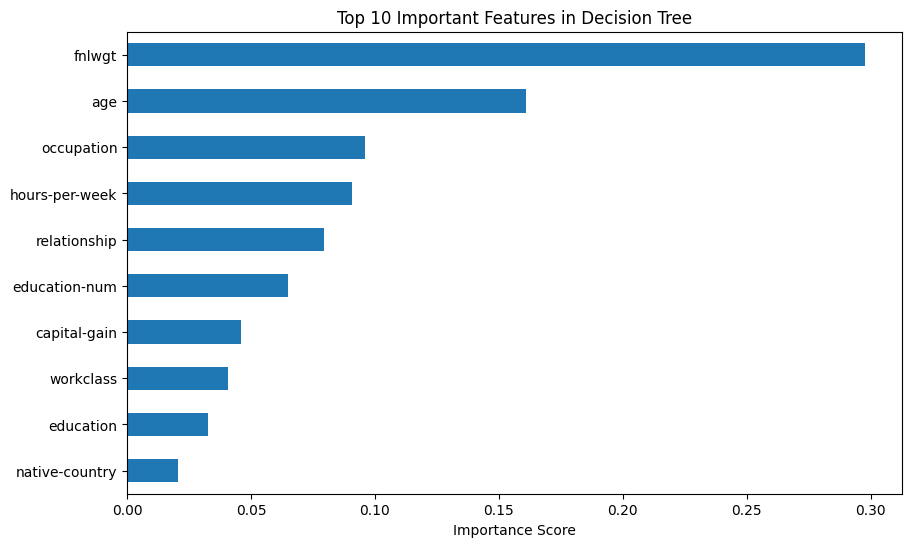

In [15]:
#Identify the most important features (which features are used at the top of the tree).
import matplotlib.pyplot as plt
import numpy as np

best_clf = DecisionTreeClassifier(max_depth=None, criterion='gini', random_state=42)
best_clf.fit(X_train, y_train)

feature_importances = pd.Series(best_clf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("\n🔹 Top 10 Most Important Features:\n")
print(feature_importances.head(10))

plt.figure(figsize=(10,6))
feature_importances.head(10).plot(kind='barh')
plt.title("Top 10 Important Features in Decision Tree")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()